In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

import CtllDes 
from CtllDes.core import ctll, satellite


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy as astr
import astropy.units as u
import astropy

In [3]:
from poliastro.bodies import Earth, Sun
from poliastro.frames import Planes
from poliastro.constants import J2000
from poliastro.ephem import Ephem

# Define a function using poliastro utilities in order to obtain the sun-earth vector
this could be added to the library if needed, but I don't think is appropriate since every utility comes from poliastro and astropy libraries.

# Defining specifications and parameters constraints

## <strong>Instruments</strong>

In [4]:
import CtllDes.core.instrument as instr

In [5]:
ROLL_ANGLE = 30*u.deg

### 1st instrument

In [6]:
pixel_width_1 = 28*1E-6*u.m
n_pixels_1 = 3072
sensor_width_1 = n_pixels_1*pixel_width_1
f_length_1 = 17*1E-2*u.m

In [7]:
instr_1 = instr.RollCamera(f_length_1, sensor_width_1, ROLL_ANGLE)

### 2nd instrument 

In [8]:
pixel_width_2 = 7*1E-6*u.m
n_pixels_2 = 12288
sensor_width_2 = n_pixels_2*pixel_width_2
f_length_2 = 4.2*u.m

In [9]:
instr_2 = instr.RollCamera(f_length_2, sensor_width_2, ROLL_ANGLE)

## <strong>Targets</strong>

In [10]:
from CtllDes.targets.targets import Target, Targets

### 1st instrument targets

In [11]:
bs_as = Targets.from_state("Buenos Aires", N=8)
rio_negro = Targets.from_state("Río Negro", N=10)

### 2nd instrument targets

In [12]:
gba = Targets.from_state("Ciudad de Buenos Aires", N=8) 
cordoba_city = Target.from_city('Córdoba',country='AR')
rosario_city = Target.from_city('Rosario',country='AR')

### <strong>Ground Stations</strong>

In [13]:
MIN_ELEVATION = 15*u.deg
DOWN_RATE = 300*1E6*u.bit/u.s

In [14]:
gs_1 = Target(-64.45, -31.58333)
gs_2 = Target(-58.718, -34.411)

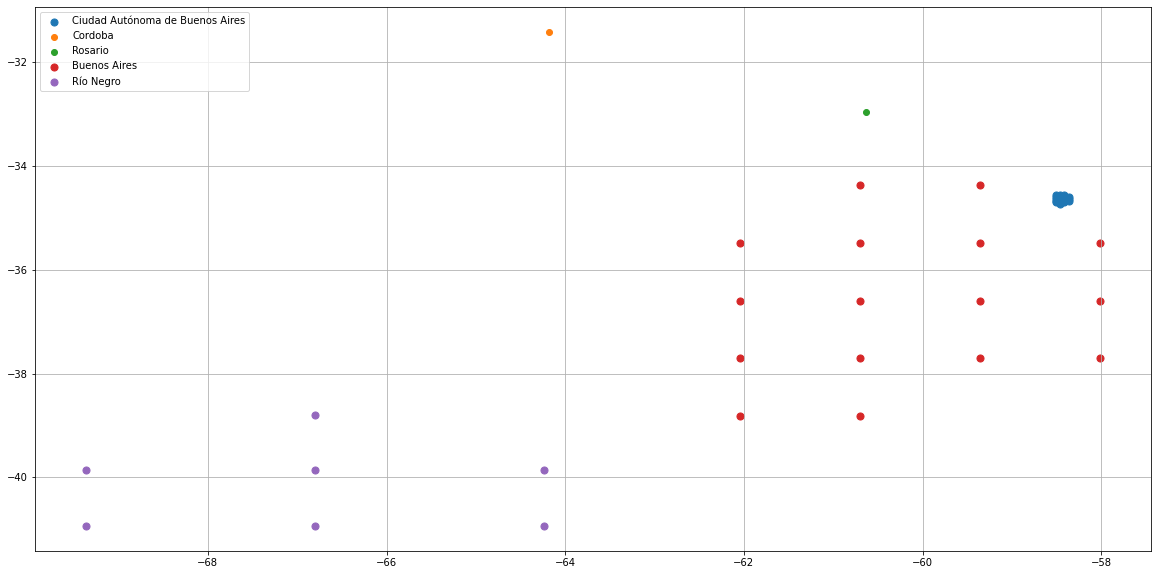

In [15]:
fig = plt.figure(figsize=(20,10))
plt.grid()

plt.scatter(gba.lons,gba.lats,s=50,label='Ciudad Autónoma de Buenos Aires')
plt.scatter(cordoba_city.lon,cordoba_city.lat,label='Cordoba')
plt.scatter(rosario_city.lon,rosario_city.lat,label='Rosario')


plt.scatter(bs_as.lons,bs_as.lats,s=50,label='Buenos Aires')
plt.scatter(rio_negro.lons,rio_negro.lats,s=50,label='Río Negro')

plt.legend(loc=2)

### <strong>Orbits</strong>

In [16]:
H_MIN = 550*u.km
H_MAX = 650*u.km
MAX_INC = 45*u.deg

R = Earth.R_mean.to(u.km)

R_MIN = R + H_MIN
R_MAX = R + H_MAX

In [17]:
from CtllDes.utils import sscalc

D = 3 #days for revisit
orb_df = sscalc.helio_rgt_synchronous(D) #dataframe
orb_df.head() #radius [km], inclination [degrees], revolutions per day.

,radius,inc,N
0,11549.628629,142.101524,7.000000
1,11196.684826,135.067101,7.333333
2,10869.554031,129.657165,7.666667
3,10565.337007,125.300767,8.000000
4,10281.565346,121.693395,8.333333


In [18]:
filtered_orbits  = orb_df.loc[(orb_df['radius'] > R_MIN.value) & (orb_df['radius'] < R_MAX.value)]
filtered_orbits

,radius,inc,N
24,6947.854468,97.66328,15.0


### Extract semi major axis length = to radius, and inclination.

In [19]:
a = filtered_orbits['radius'].values[0]
a *= u.km
a

<Quantity 6947.85446754 km>

In [20]:
inc = filtered_orbits['inc'].values[0]
inc *= u.deg
inc

<Quantity 97.66328018 deg>

### Define the rest of the classical orbit parameters

In [65]:
ecc = 0*u.one
raan = -30 * u.deg # right ascencion of the ascending node [angle]
argp = 0 * u.rad # perigee argument [angle]
nu = 0 * u.deg # true anomaly [angle] defined as -180 so that it coincides with LTDN

### Build orbit

In [66]:
from poliastro.twobody import Orbit

orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)

In [67]:
print(orb.r)
print(orb.v)

[ 6017.01847068 -3473.92723377     0.        ] km
[-0.50502164 -0.87472315  7.50667069] km / s


In [68]:
sat = satellite.Sat.from_orbit(orb)

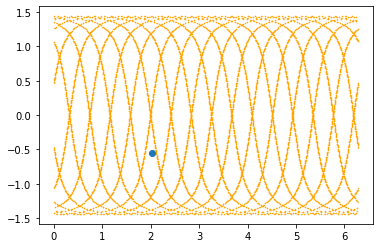

In [69]:
r,v = sat.rv(10,dt=50,J2=True)
lon,lat = sat.ssps_from_r(r,10,dt=50,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad) )

In [44]:
from CtllDes.utils import angles, sunearth

today = astropy.time.Time({'year': 2021, 'month': 5, 'day': 31,'hour': 12, 'minute': 0, 'second': 0}, scale='utc')
new_raan = angles.get_passage_raan(sat, cordoba_city.lon*u.deg, cordoba_city.lat*u.deg)
new_raan

<Quantity -0.26795596 rad>

In [70]:
from poliastro.twobody import Orbit

orb2 = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            new_raan+sat.orbit.raan,
                            argp,
                            nu)
sat2 = satellite.Sat.from_orbit(orb2)

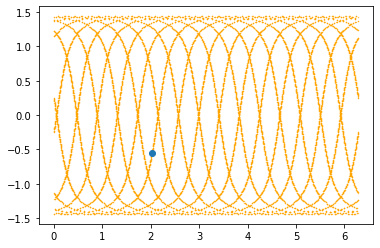

In [71]:
r,v = sat2.rv(10,dt=50,J2=True)
lon,lat = sat2.ssps_from_r(r,10,dt=50,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad) )

In [72]:
lon_offset = angles.get_passage_LTDN(sat2, epoch=today.tdb, LTDN=12*u.h)
lon_offset.to(u.deg)

<Quantity 66.3018862 deg>

In [73]:
from poliastro.twobody import Orbit

orb3 = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            new_raan-lon_offset+sat.orbit.raan,
                            argp,
                            nu)
sat3 = satellite.Sat.from_orbit(orb3)

In [74]:
angles.get_passage_LTDN(sat3, epoch=today.tdb, LTDN=12*u.h)

<Quantity 2.49864668e-07 rad>